## Image segmentation of Synthetic Unity data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = Path('/home/ruslan/Desktop/Unity/ImageSynthUnity/dataset')
path.ls()

[PosixPath('/home/ruslan/Desktop/Unity/ImageSynthUnity/dataset/val'),
 PosixPath('/home/ruslan/Desktop/Unity/ImageSynthUnity/dataset/models'),
 PosixPath('/home/ruslan/Desktop/Unity/ImageSynthUnity/dataset/train')]

## Data

In [4]:
fnames = list((path/'train').glob('*img*'))
fnames[:3]

[PosixPath('/home/ruslan/Desktop/Unity/ImageSynthUnity/dataset/train/Windridge City Demo Scene_49_img.png'),
 PosixPath('/home/ruslan/Desktop/Unity/ImageSynthUnity/dataset/train/Windridge City Demo Scene_122_img.png'),
 PosixPath('/home/ruslan/Desktop/Unity/ImageSynthUnity/dataset/train/Windridge City Demo Scene_116_img.png')]

In [5]:
lbl_names = list((path/'train').glob('*layer*'))
lbl_names[:3]

[PosixPath('/home/ruslan/Desktop/Unity/ImageSynthUnity/dataset/train/Windridge City Demo Scene_215_layer.png'),
 PosixPath('/home/ruslan/Desktop/Unity/ImageSynthUnity/dataset/train/Windridge City Demo Scene_44_layer.png'),
 PosixPath('/home/ruslan/Desktop/Unity/ImageSynthUnity/dataset/train/Windridge City Demo Scene_57_layer.png')]

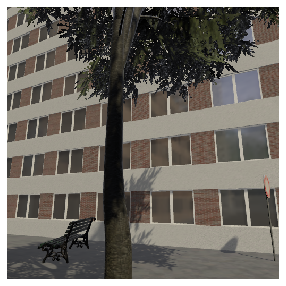

In [6]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [7]:
get_y_fn = lambda x: str(x).replace('img', 'layer')

In [8]:
open_image(get_y_fn(img_f), convert_mode='L').data.unique()

tensor([0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0667, 0.0706, 0.0745, 0.0824,
        0.0863, 0.0902, 0.1020, 0.1059, 0.1176])

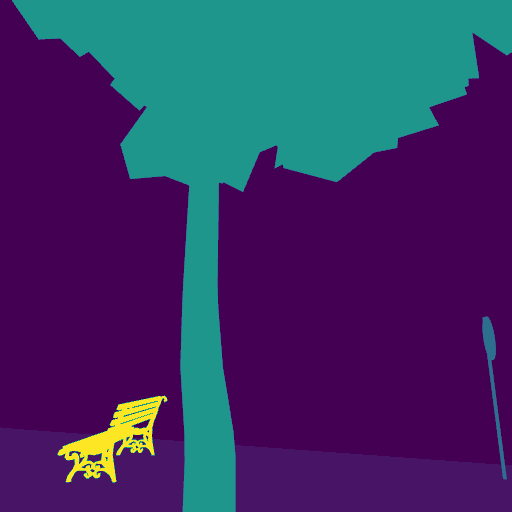

In [9]:
mask = open_mask(get_y_fn(img_f))
mask

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([512, 512]), tensor([[[11, 11, 11,  ..., 21, 21, 21],
          [11, 11, 11,  ..., 21, 21, 21],
          [11, 11, 11,  ..., 21, 21, 21],
          ...,
          [12, 12, 12,  ..., 12, 12, 12],
          [12, 12, 12,  ..., 12, 12, 12],
          [12, 12, 12,  ..., 12, 12, 12]]]))

In [11]:
np.unique(mask.data)

array([11, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 26, 27, 30])

In [12]:
codes = np.array(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30"])

## Datasets

In [13]:
size = src_size//2
bs = 8

In [14]:
def just_images(x):
    return 'img' in str(x)

src = (SegmentationItemList.from_folder(path)
     .filter_by_func(just_images)
     .split_by_folder(train='train', valid='val')
     .label_from_func(get_y_fn, classes=codes))
src

LabelLists;

Train: LabelList (250 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /home/ruslan/Desktop/Unity/ImageSynthUnity/dataset;

Valid: LabelList (62 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /home/ruslan/Desktop/Unity/ImageSynthUnity/dataset;

Test: None

In [15]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

### Train data sample

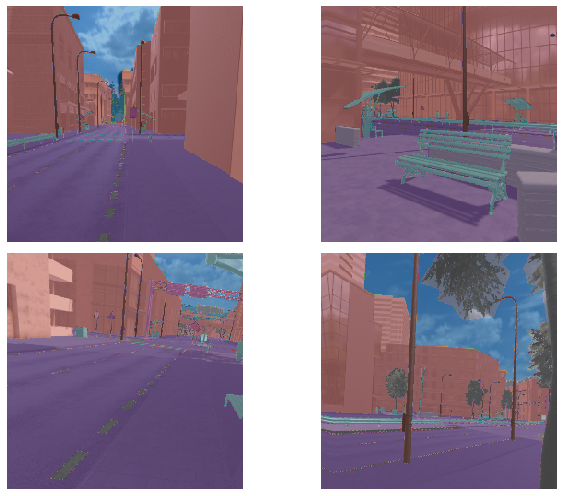

In [16]:
data.show_batch(2, figsize=(10,7))

### Validation data sample

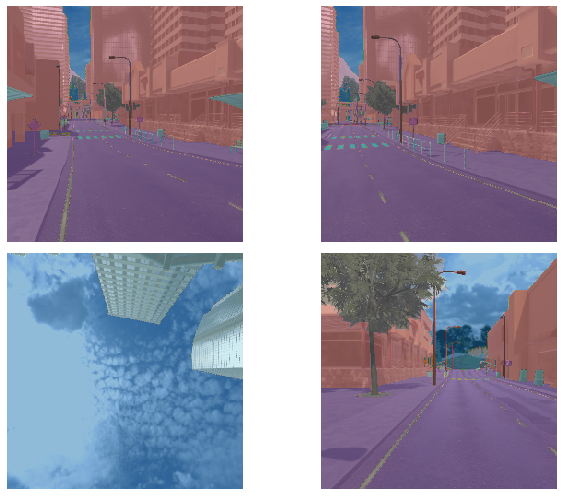

In [18]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['0']

def acc_segmentation(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [20]:
metrics=acc_segmentation

In [21]:
wd=1e-2

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [23]:
import torch
torch.cuda.is_available()

True

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


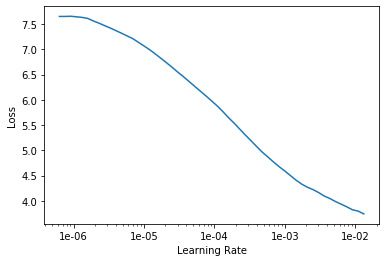

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr=1e-3

In [30]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_segmentation,time
0,1.565537,1.311641,0.546523,00:50
1,1.374907,1.122819,0.639345,00:50
2,1.159271,0.853791,0.715091,00:50
3,0.982188,0.861391,0.739165,00:50
4,0.849385,0.765543,0.784687,00:50
5,0.775589,0.762227,0.786490,00:22
6,0.719985,0.608659,0.804574,00:15
7,0.652738,0.720577,0.793283,00:15
8,0.624442,0.604356,0.830759,00:15
9,0.568889,0.613379,0.819437,00:15


In [31]:
learn.save('stage-1')

In [32]:
learn.load('stage-1');

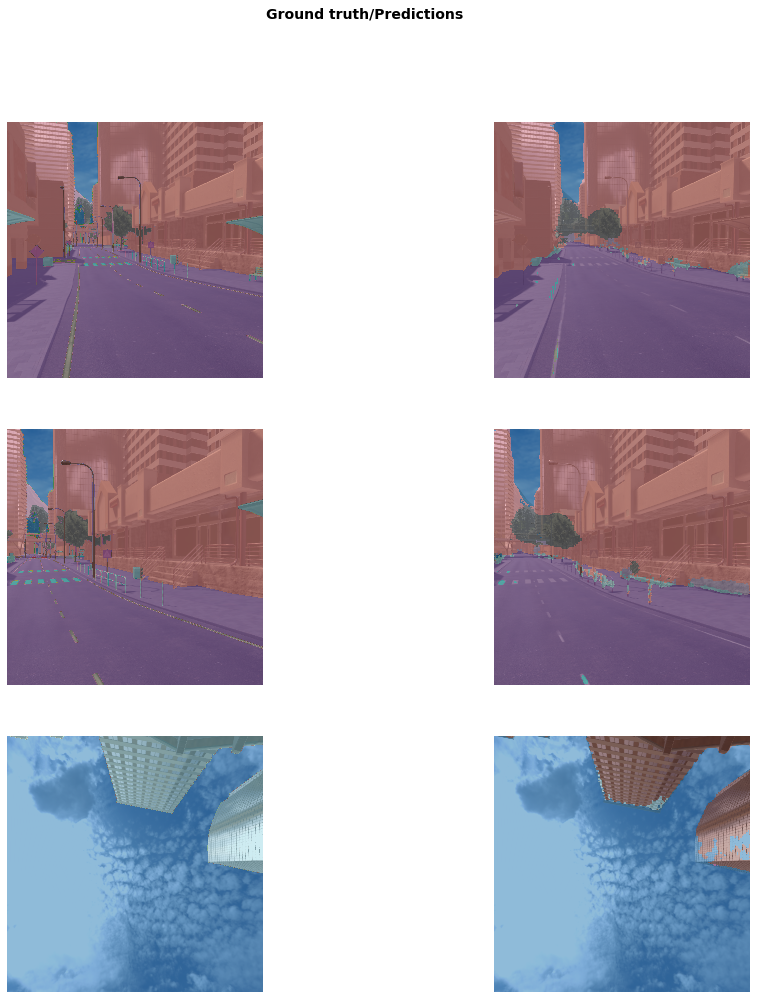

In [33]:
learn.show_results(rows=3, figsize=(16,16))

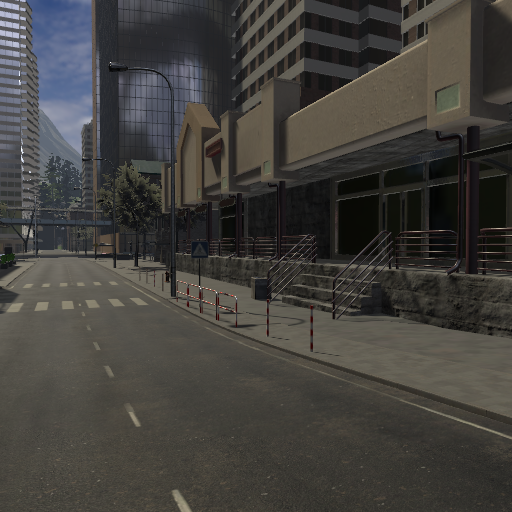

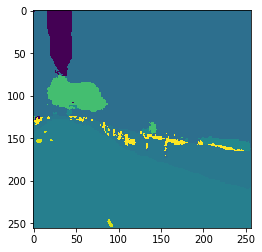

In [38]:
img = open_image((path/'val').ls()[3])
display(img)
plt.imshow(learn.predict(img)[1].squeeze())

In [35]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
size = src_size
bs=3

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin